# Лабораторная работа №4: Кластеризация кредитоспособности клиентов немецкого банка

**Цель работы:**  
Исследовать методы кластеризации на примере данных о клиентах немецкого банка и выполнить группировку клиентов по сходным характеристикам.  
В работе используются методы K-means и иерархической кластеризации, а также визуальные и численные критерии выбора числа кластеров и оценки качества разбиения.


In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    rand_score
)

from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

# Загружаем данные
data_path = 'german_credit_data.csv'
df = pd.read_csv(data_path)

df.head()

## Описание датасета

Датасет содержит информацию о клиентах немецкого банка и их кредитах.  
Основные признаки:

- **Age** — возраст клиента;  
- **Sex** — пол;  
- **Job** — уровень занятости / должностной статус;  
- **Housing** — тип жилья (own, rent, free);  
- **Saving accounts** — состояние сберегательного счёта;  
- **Checking account** — состояние расчётного счёта;  
- **Credit amount** — сумма кредита;  
- **Duration** — срок кредита (в месяцах);  
- **Purpose** — цель кредита;  
- **Risk** — качественная оценка кредитоспособности клиента (good / bad).

В задаче кластеризации мы будем рассматривать признак *Risk* как дополнительный (внешний) критерий оценки кластеров, но при формировании самих кластеров он использоваться не будет.


In [ ]:
# Размерность, типы признаков, пропуски
print('Форма датафрейма:', df.shape)
print('\nИнформация о данных:')
print(df.info())

print('\nЧисловые признаки:')
print(df.select_dtypes(include=['int64', 'float64']).describe().T)

print('\nКатегориальные признаки:')
print(df.select_dtypes(include=['object']).describe().T)

# Проверим пропуски
print('\nЧисло пропусков по столбцам:')
print(df.isna().sum())

numeric_features = ['Age', 'Credit amount', 'Duration']

ax = df[numeric_features].hist(bins=20, figsize=(12, 4))
plt.suptitle('Гистограммы распределения числовых признаков', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


### Визуализация распределений признаков

Построим гистограммы для основных числовых признаков и оценим наличие выбросов и отклонение от нормального распределения.

### Матрица диаграмм рассеивания

Для предварительной визуальной оценки структуры данных построим матрицу диаграмм рассеивания для числовых признаков.

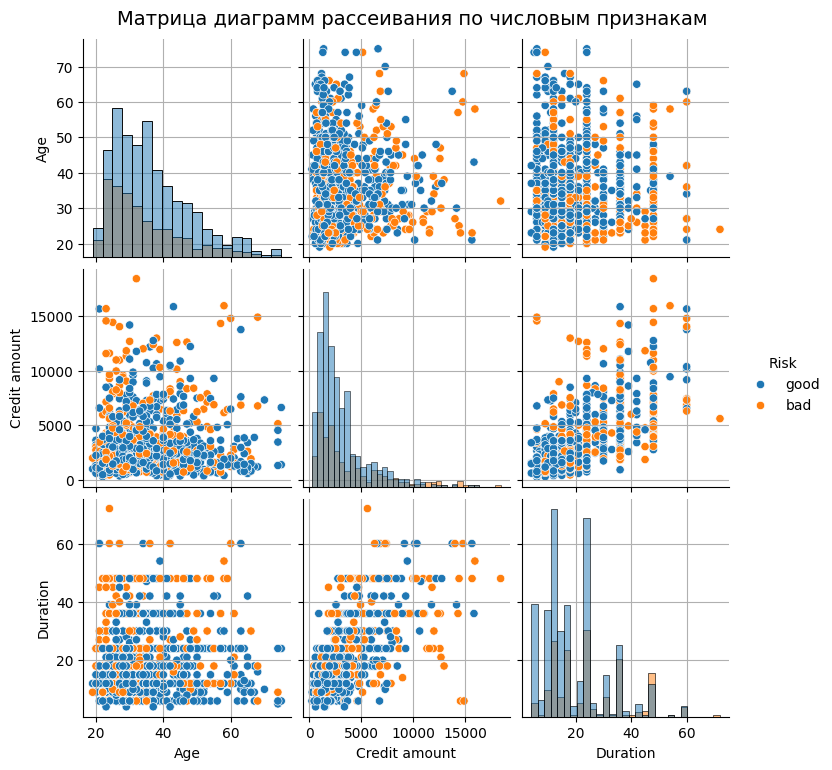

In [10]:
g = sns.pairplot(df[numeric_features + ['Risk']], hue='Risk', diag_kind='hist')
g.fig.suptitle('Матрица диаграмм рассеивания по числовым признакам', y=1.02, fontsize=14)
plt.show()

Проводим анализ выбросов

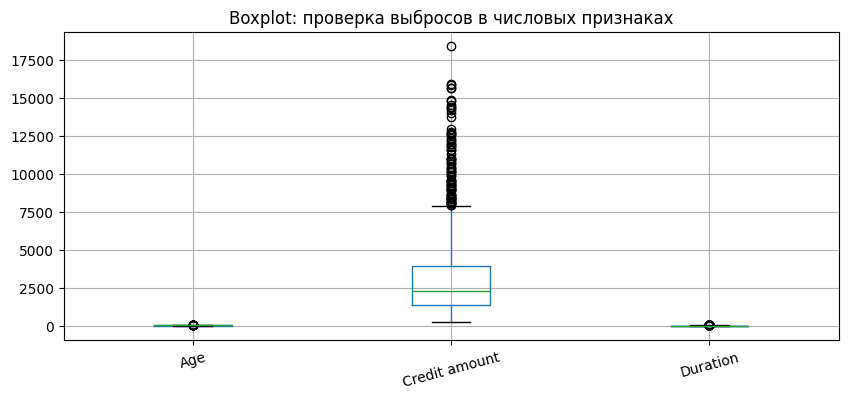

,Feature,OutlierShare(IQR)
0,Age,0.023
1,Credit amount,0.072
2,Duration,0.070


In [11]:
import numpy as np
import matplotlib.pyplot as plt

numeric_features = ['Age', 'Credit amount', 'Duration']

# Boxplot
plt.figure(figsize=(10, 4))
df[numeric_features].boxplot()
plt.title('Boxplot: проверка выбросов в числовых признаках')
plt.xticks(rotation=15)
plt.show()

# IQR-оценка доли выбросов
outlier_stats = []
for col in numeric_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = ((df[col] < lower) | (df[col] > upper)).mean()
    outlier_stats.append([col, outliers])

outlier_df = pd.DataFrame(outlier_stats, columns=['Feature', 'OutlierShare(IQR)'])
outlier_df


## Предобработка данных и масштабирование

Для корректной работы алгоритмов кластеризации, основанных на расстояниях (особенно K-means и иерархической кластеризации с евклидовым расстоянием), необходимо привести числовые признаки к одному масштабу.

Мы будем использовать **StandardScaler**, который вычитает среднее и делит на стандартное отклонение.  
Категориальные признаки закодируем методом **One-Hot Encoding**.

In [12]:
# Удаляем технический столбец
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Целевая переменная для внешней оценки (использоваться в кластеризации не будет)
y_raw = df['Risk']
y = y_raw.map({'good': 0, 'bad': 1})

X = df.drop(columns=['Risk'])

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Числовые признаки:', numeric_cols)
print('Категориальные признаки:', categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_scaled = preprocessor.fit_transform(X)

print('Форма матрицы признаков после кодирования и масштабирования:', X_scaled.shape)

Числовые признаки: ['Age', 'Job', 'Credit amount', 'Duration']
Категориальные признаки: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Форма матрицы признаков после кодирования и масштабирования: (1000, 26)


Проведём информационную значимость признаков

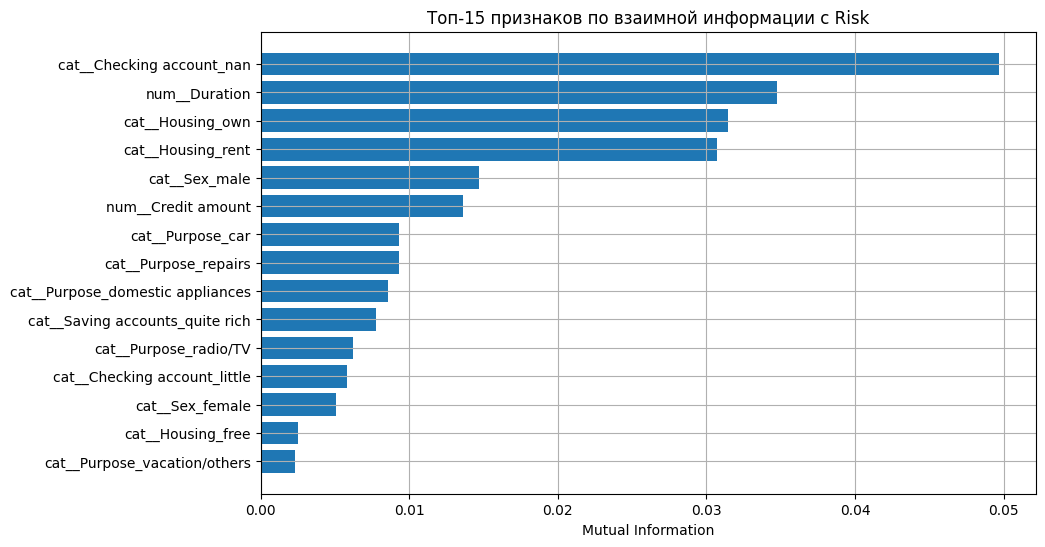

,Feature,MutualInfo(Risk)
17,cat__Checking account_nan,0.049673
3,num__Duration,0.034731
7,cat__Housing_own,0.031429
8,cat__Housing_rent,0.030695
5,cat__Sex_male,0.014718
2,num__Credit amount,0.013607
19,cat__Purpose_car,0.009334
24,cat__Purpose_repairs,0.009301
20,cat__Purpose_domestic appliances,0.008569
11,cat__Saving accounts_quite rich,0.007790


In [13]:
from sklearn.feature_selection import mutual_info_classif

# Используем уже подготовленные X (без Risk) и y_risk (0/1)
y_risk = df['Risk'].map({'good': 0, 'bad': 1})

X_tmp = df.drop(columns=['Risk'])
# Чтобы MI работал, нужно закодировать категориальные + заполнить пропуски.
# Можно переиспользовать твой preprocessor, но без StandardScaler тоже ок.
X_encoded = preprocessor.fit_transform(X_tmp)

mi = mutual_info_classif(
    X_encoded.toarray() if hasattr(X_encoded, "toarray") else X_encoded,
    y_risk,
    random_state=RANDOM_STATE
)

feature_names = preprocessor.get_feature_names_out()
mi_df = pd.DataFrame({'Feature': feature_names, 'MutualInfo(Risk)': mi}).sort_values('MutualInfo(Risk)', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mi_df.head(15)['Feature'][::-1], mi_df.head(15)['MutualInfo(Risk)'][::-1])
plt.title('Топ-15 признаков по взаимной информации с Risk')
plt.xlabel('Mutual Information')
plt.show()

mi_df.head(15)


In [14]:
from itertools import combinations

def partition_jaccard(labels_true, labels_pred):
    """
    Индекс Жаккара для двух разбиений множества объектов на кластеры.
    Считается по парам объектов:
    J = M11 / (M11 + M10 + M01)
    """
    n = len(labels_true)
    M11 = M10 = M01 = 0

    for i, j in combinations(range(n), 2):
        same_true = (labels_true[i] == labels_true[j])
        same_pred = (labels_pred[i] == labels_pred[j])

        if same_true and same_pred:
            M11 += 1
        elif same_true and not same_pred:
            M10 += 1
        elif not same_true and same_pred:
            M01 += 1

    if M11 + M10 + M01 == 0:
        return 0.0
    return M11 / (M11 + M10 + M01)

## Метод K-means: подбор числа кластеров

Для выбора количества кластеров k используем метод локтя и силуэтный анализ.

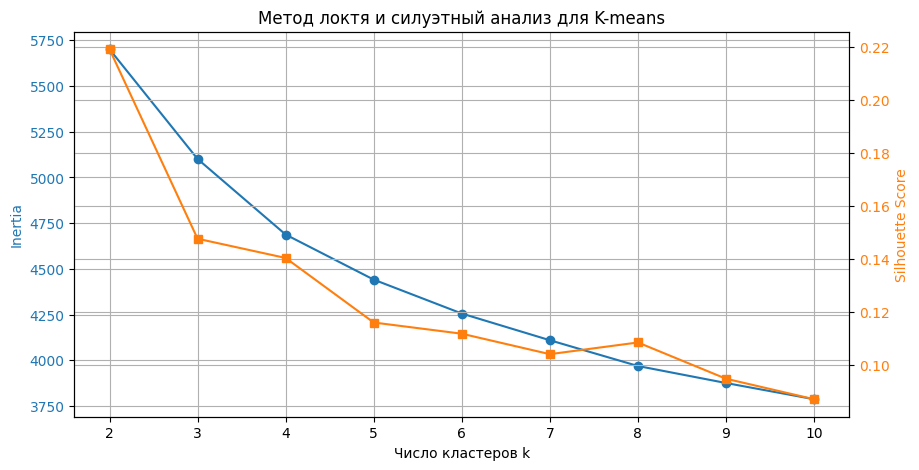

Наилучшее k по силуэтному коэффициенту: 2


In [15]:
inertias = []
silhouettes = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouettes.append(sil_score)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Число кластеров k')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_values, inertias, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, silhouettes, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Метод локтя и силуэтный анализ для K-means')
plt.show()

best_k_sil = k_values[int(np.argmax(silhouettes))]
print('Наилучшее k по силуэтному коэффициенту:', best_k_sil)

### Итоговая модель K-means

Выберем значение k, которое даёт наибольший силуэтный коэффициент (или визуально разумно выглядит на графике), и обучим итоговую модель K-means.

In [16]:
k_opt = best_k_sil  # при необходимости можно задать вручную, например k_opt = 3

kmeans_final = KMeans(n_clusters=k_opt, n_init=10, random_state=RANDOM_STATE)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
rand_kmeans = rand_score(y, kmeans_labels)
jaccard_kmeans = partition_jaccard(y.to_numpy(), kmeans_labels)

print('K-means (k = {})'.format(k_opt))
print('Silhouette Score:', sil_kmeans)
print('Calinski–Harabasz Index:', ch_kmeans)
print('Adjusted Rand Index:', ari_kmeans)
print('Rand Index:', rand_kmeans)
print('Jaccard Index (по парам объектов):', jaccard_kmeans)

K-means (k = 2)
Silhouette Score: 0.2192682083026472
Calinski–Harabasz Index: 212.7478131699023
Adjusted Rand Index: 0.08827640986530358
Rand Index: 0.5650870870870871
Jaccard Index (по парам объектов): 0.4756480811006517


## Иерархическая кластеризация

Рассмотрим иерархическую кластеризацию с использованием метода связей Ward.  
Сначала построим дендрограмму, чтобы визуально оценить возможное количество кластеров.

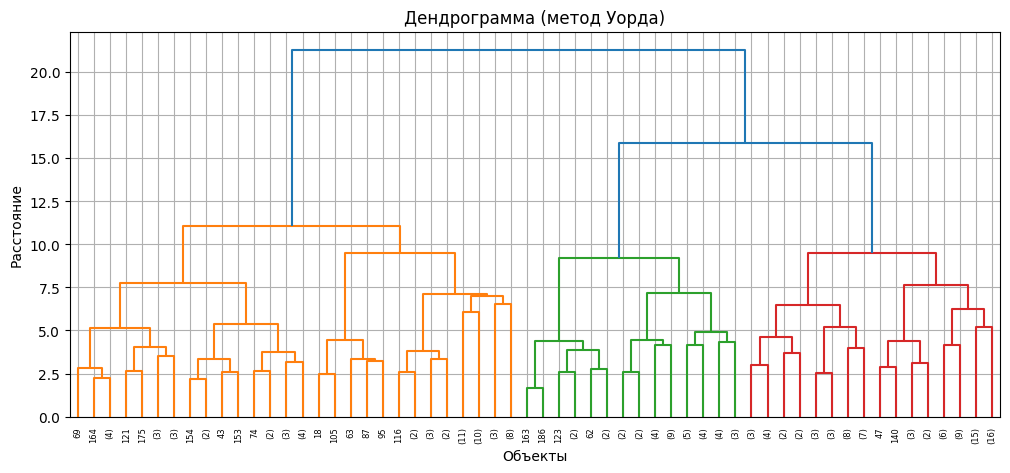

In [17]:
# Для дендрограммы возьмём подмножество объектов (например, 200), чтобы график был читаемым
sample_size = min(200, X_scaled.shape[0])
X_sample = X_scaled[:sample_size]

linked = linkage(X_sample.todense() if hasattr(X_sample, 'todense') else X_sample, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='level', p=5)
plt.title('Дендрограмма (метод Уорда)')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

### Итоговая модель иерархической кластеризации

Выберем то же количество кластеров, что и для K-means, чтобы результаты было удобнее сравнивать.

In [18]:
agglo = AgglomerativeClustering(n_clusters=k_opt, linkage='ward')
agglo_labels = agglo.fit_predict(X_scaled.toarray() if hasattr(X_scaled, 'toarray') else X_scaled)

sil_agglo = silhouette_score(X_scaled, agglo_labels)
ch_agglo = calinski_harabasz_score(X_scaled, agglo_labels)
ari_agglo = adjusted_rand_score(y, agglo_labels)
rand_agglo = rand_score(y, agglo_labels)
jaccard_agglo = partition_jaccard(y.to_numpy(), agglo_labels)

print('Agglomerative (k = {})'.format(k_opt))
print('Silhouette Score:', sil_agglo)
print('Calinski–Harabasz Index:', ch_agglo)
print('Adjusted Rand Index:', ari_agglo)
print('Rand Index:', rand_agglo)
print('Jaccard Index (по парам объектов):', jaccard_agglo)

Agglomerative (k = 2)
Silhouette Score: 0.21071380399921827
Calinski–Harabasz Index: 176.52238786740972
Adjusted Rand Index: 0.07787366896568097
Rand Index: 0.568018018018018
Jaccard Index (по парам объектов): 0.494672131147541


## Сравнение качества кластеризации разных методов

In [19]:
results = pd.DataFrame({
    'Метод': ['K-means', 'Agglomerative'],
    'Silhouette': [sil_kmeans, sil_agglo],
    'Calinski-Harabasz': [ch_kmeans, ch_agglo],
    'Adjusted Rand Index': [ari_kmeans, ari_agglo],
    'Rand Index': [rand_kmeans, rand_agglo],
    'Jaccard Index': [jaccard_kmeans, jaccard_agglo]
})
results

,Метод,Silhouette,Calinski-Harabasz,Adjusted Rand Index,Rand Index,Jaccard Index
0,K-means,0.219268,212.747813,0.088276,0.565087,0.475648
1,Agglomerative,0.210714,176.522388,0.077874,0.568018,0.494672


## Влияние числа кластеров на качество кластеризации (K-means)

Исследуем, как изменение количества кластеров влияет на показатели качества.

,k,Silhouette,Calinski-Harabasz
0,2,0.219268,212.747813
1,3,0.147713,177.399982
2,4,0.140445,157.849002
3,5,0.116078,138.625366
4,6,0.111847,124.278109
5,7,0.104124,113.013808
6,8,0.108539,105.240487
7,9,0.094852,97.169943
8,10,0.087110,90.879304


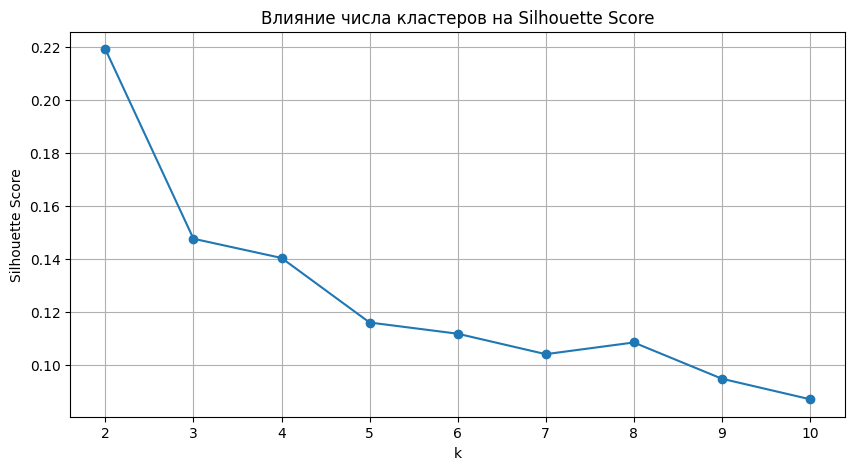

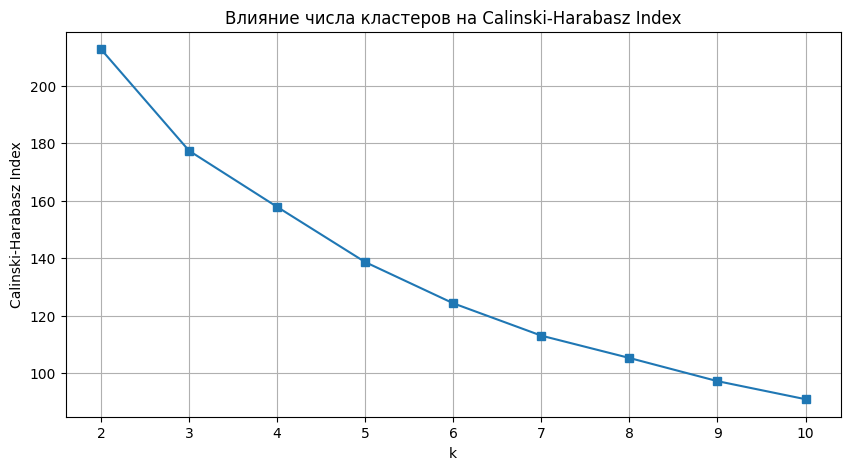

In [20]:
metrics_k = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    metrics_k.append({'k': k, 'Silhouette': sil, 'Calinski-Harabasz': ch})

metrics_k_df = pd.DataFrame(metrics_k)
display(metrics_k_df)

fig, ax1 = plt.subplots()
ax1.plot(metrics_k_df['k'], metrics_k_df['Silhouette'], marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Влияние числа кластеров на Silhouette Score')
plt.show()

plt.figure()
plt.plot(metrics_k_df['k'], metrics_k_df['Calinski-Harabasz'], marker='s')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Влияние числа кластеров на Calinski-Harabasz Index')
plt.show()

## Визуализация полученных кластеров

Для визуализации кластеров в двумерном пространстве применим метод главных компонент (PCA) и изобразим точки на плоскости, раскрасив их по принадлежности к кластерам и по исходному признаку Risk.

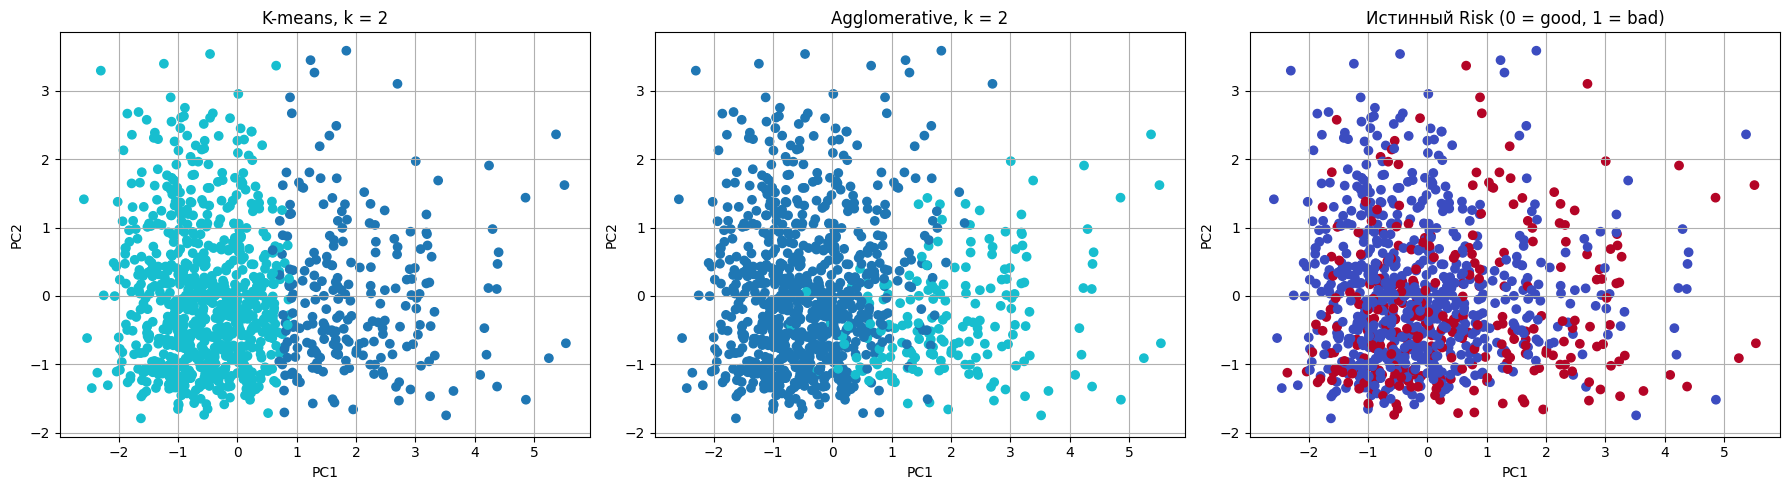

In [21]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled.toarray() if hasattr(X_scaled, 'toarray') else X_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
axes[0].set_title('K-means, k = {}'.format(k_opt))
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='tab10')
axes[1].set_title('Agglomerative, k = {}'.format(k_opt))
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm')
axes[2].set_title('Истинный Risk (0 = good, 1 = bad)')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

plt.tight_layout()
plt.show()

## Интерпретация центров кластеров (K-means)

Для интерпретации кластеров преобразуем центры кластеров K-means обратно в пространство исходных признаков.

In [22]:
# Получаем центры в пространстве масштабированных и закодированных признаков
centers_scaled = kmeans_final.cluster_centers_

# Преобразуем их обратно в пространство исходных признаков
# Для этого используем обратное преобразование ColumnTransformer
def inverse_transform_centers(preprocessor, centers_scaled):
    # ColumnTransformer не имеет прямого inverse_transform для всех трансформеров одновременно,
    # поэтому извлекаем части отдельно.
    num_pipeline = preprocessor.named_transformers_['num']
    cat_pipeline = preprocessor.named_transformers_['cat']
    ohe = cat_pipeline.named_steps['onehot']

    n_num = len(numeric_cols)
    n_cat = centers_scaled.shape[1] - n_num

    centers_num_scaled = centers_scaled[:, :n_num]
    centers_cat_encoded = centers_scaled[:, n_num:]

    centers_num = num_pipeline.named_steps['scaler'].inverse_transform(centers_num_scaled)

    centers_cat_indices = centers_cat_encoded.reshape(centers_cat_encoded.shape[0], -1).argmax(axis=1)

    # Восстановим категории для каждого кат. признака (грубое приближение)
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    cat_df = pd.DataFrame(columns=categorical_cols)

    start = 0
    for col in categorical_cols:
        n_categories = len([f for f in cat_feature_names if f.startswith(col + '_')])
        idx_slice = centers_cat_encoded[:, start:start + n_categories]
        max_indices = idx_slice.argmax(axis=1)
        categories = [f.split('_', 1)[1] for f in cat_feature_names[start:start + n_categories]]
        recovered = [categories[i] for i in max_indices]
        cat_df[col] = recovered
        start += n_categories

    num_df = pd.DataFrame(centers_num, columns=numeric_cols)
    centers_original = pd.concat([num_df, cat_df], axis=1)
    return centers_original

centers_original = inverse_transform_centers(preprocessor, centers_scaled)
centers_original

,Age,Job,Credit amount,Duration,Sex,Housing,Saving accounts,Checking account,Purpose
0,36.640693,2.285714,7150.588745,36.701299,male,own,little,moderate,car
1,35.217165,1.789337,2105.945384,16.157347,male,own,little,nan,car


## Заключение

В лабораторной работе была проведена кластеризация клиентов немецкого банка на основе их социально-демографических и финансовых характеристик.  
Были реализованы два метода кластеризации — K-means и иерархическая кластеризация (метод Уорда), а также выполнен подбор числа кластеров с использованием метода локтя и силуэтного анализа.

Для оценки качества кластеризации использовались внутренние метрики, а также внешние метрики ( по типу индекса Жаккара), основанные на сравнении кластеров с известной меткой кредитоспособности.  
Сравнение результатов показало, что оба метода выделяют сходные группы клиентов, однако численные значения метрик и визуальный анализ кластеров позволяют сделать вывод о различиях в форме и компактности полученных групп.

Интерпретация центров кластеров K-means показала, что выделенные группы соответствуют различным типам клиентов: условно более надёжные (good) и более рискованные (bad) с различиями в возрасте, сумме и сроке кредита, а также типах счетов и целей кредитования.  
В целом методы кластеризации демонстрируют применимость для предварительного сегментирования клиентов и могут служить основой для более сложных моделей кредитного скоринга и таргетированных продуктов банка.
